In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from collections import Counter
from scipy.stats import pearsonr
import subprocess
from scipy.spatial.distance import braycurtis
%matplotlib inline
import time
from Bio import Entrez
Entrez.email = 'liaochen1988@gmail.com'
from Bio import SeqIO

# Step 1: Find oral-typical ASVs in Theis et al. but not in MOMD

## Read metadata

In [2]:
df_meta = pd.read_csv('Theis_mSphere2020_qiime2_output/SraRunTable.txt')[['Run','source_material_ID']]
df_meta.columns = ['SampleID','SampleName']
df_meta = df_meta[df_meta.SampleName.str.contains('Maternal')]
df_meta = df_meta[(df_meta.SampleName.str.contains('Oral')) | (df_meta.SampleName.str.contains('Intestine'))]
df_meta['BodySite'] = [x.split('_')[1] for x in df_meta.SampleName]
df_meta['Mouse'] = [x.split('_')[-1] for x in df_meta.SampleName]
df_meta = df_meta.set_index('SampleID')
df_meta = df_meta[df_meta.BodySite != 'Proximal']
df_meta.head()

,SampleName,BodySite,Mouse
SampleID,,,
SRR10664986,Maternal_Oral_M6,Oral,M6
SRR10664989,Maternal_Oral_M10,Oral,M10
SRR10665002,Maternal_Oral_M5,Oral,M5
SRR10665005,Maternal_Distal_Intestine_M12,Distal,M12
SRR10665009,Maternal_Distal_Intestine_M8,Distal,M8


## Read taxonomy data

In [3]:
df_tax = pd.read_csv('Theis_mSphere2020_qiime2_output/taxonomy.tsv', sep="\t")
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
df_tax.head()

,Feature ID,Taxon,Confidence,LowestTaxonomy
0,ff2be076cf928bdf0eb0935b49878911,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.983031,s__Streptococcus_danieliae
1,95fdd816723ca482a5caba10bea171c8,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999987,g__Lactobacillus
2,b4f3850fd3c56b21b6eb92fc8e4c7087,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.843519,s__Muribacter_muris
3,f80166d86a7f15b69b6ac97505299c3a,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.999823,g__Muribaculaceae
4,7f9b6e8f00d7dee79027e94f592ed7d7,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,0.837048,g__Rodentibacter


## Read count data

In [4]:
df_count = pd.read_csv('Theis_mSphere2020_qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", skiprows=[0], index_col=0)
df_count = df_count.loc[df_tax['Feature ID']].T
df_count = df_count.loc[df_meta.index]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
print("minimum total count = %d" % df_count.sum(axis=1).min())
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)
df_relabun.head()

minimum total count = 47032


#OTU ID,ff2be076cf928bdf0eb0935b49878911,95fdd816723ca482a5caba10bea171c8,b4f3850fd3c56b21b6eb92fc8e4c7087,f80166d86a7f15b69b6ac97505299c3a,7f9b6e8f00d7dee79027e94f592ed7d7,e06e73c0550bfd3f63b73915855c10b6,d04b16de2b3bfa84754a4eafcfaec69a,499f1c879aa937fd84ec658999d69c43,4f983ab505c9e0936ecafdda621aead9,8e6f1849d93723676dff6cb1962941a8,...,57e004c428aa50fe1cc37bdc1d46079d,846eb3442b06d98d439a86b95886caea,f16ebdc0f55ee36421412ee28e794539,0c2d1909b9b17f119ed68d167dbf70c1,d1ec9052f7c3fe43ddd5c60db74e478f,2e82f0a6e000d1175398088dd18eec06,442f093e392d58dc3c0831d4ea5354fa,a6f36ae440733e414ff6dc7073f08970,6a488b59170dfe78137f884be500d984,e38bafa6321bd4ed4b15f934c3eb652c
SampleID,,,,,,,,,,,,,,,,,,,,,
SRR10664986,0.516117,0.074481,0.111137,0.008675,0.013948,0.095850,0.002637,0.000489,0.000319,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10664989,0.428259,0.078081,0.053979,0.040268,0.015380,0.121390,0.016713,0.039721,0.006687,0.012085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10665002,0.542537,0.012532,0.000000,0.000000,0.344050,0.083909,0.000021,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10665005,0.000217,0.018508,0.000024,0.097249,0.000000,0.000000,0.066832,0.008965,0.047458,0.028837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR10665009,0.000107,0.002261,0.000000,0.048887,0.000000,0.000000,0.035693,0.035645,0.021404,0.057251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Find oral-typical ASVs

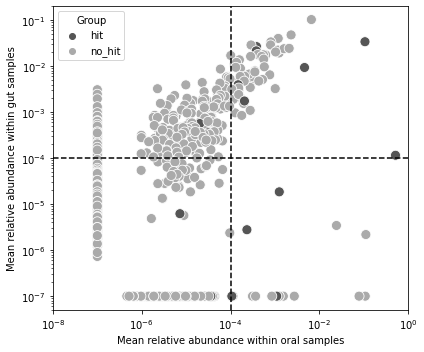

In [5]:
# find mean relative abundance of ASVs in oral and gut samples
df_relabun_mean_gut = df_relabun.loc[df_meta[df_meta.BodySite=='Distal'].index].mean(axis=0).to_frame().rename({0:'Distal'}, axis=1)
df_relabun_mean_oral = df_relabun.loc[df_meta[df_meta.BodySite=='Oral'].index].mean(axis=0).to_frame().rename({0:'Oral'}, axis=1)
#df_relabun_mean_oral = df_relabun_mean_oral[df_relabun_mean_oral.Oral>0] # keep only ASVs present in oral cavity
df_relabun_mean = pd.merge(df_relabun_mean_oral, df_relabun_mean_gut, left_index=True, right_index=True, how='left').fillna(0)

# read hits to MOMD database
df_blast_MOMD = pd.read_csv("Theis_mSphere2020_qiime2_output/asv-sequences/blast_MOMD/blast_MOMD_p100.txt", sep="\t", comment="#", header=None)
df_blast_MOMD.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_relabun_mean['Group'] = 'no_hit'
df_relabun_mean.loc[set(df_relabun_mean.index).intersection(set(df_blast_MOMD.query_accver)), 'Group'] = 'hit'
df_relabun_mean.loc[df_relabun_mean.Distal==0, 'Distal'] = 1e-7
df_relabun_mean.loc[df_relabun_mean.Oral==0, 'Oral'] = 1e-7

# plot
fig, ax = plt.subplots(figsize=(6,5), sharey=True)
_ = sns.scatterplot(x="Oral", y="Distal", data=df_relabun_mean, hue='Group', ax=ax, palette='binary_r', s=100)
_ = ax.plot([1e-8, 1e0],[1e-4,1e-4],'k--')
_ = ax.set_xlim([1e-8,1e0])
_ = ax.plot([1e-4,1e-4], [5e-8, 1e0], 'k--')
_ = ax.set_ylim([5e-8,0.2])
_ = ax.set_yscale('log')
_ = ax.set_xscale('log')
_ = ax.set_xlabel('Mean relative abundance within oral samples')
_ = ax.set_ylabel('Mean relative abundance within gut samples')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("oral_typical_Theis_et_al_MOMD_hit.svg", dpi=600, bbox_inches='tight')

In [6]:
len(df_relabun_mean[(df_relabun_mean.Oral>1e-4) & (df_relabun_mean.Distal<=1e-4)])

17

In [7]:
len(df_relabun_mean[(df_relabun_mean.Oral>1e-4) & (df_relabun_mean.Distal<=1e-4) & (df_relabun_mean.Group=='hit')])

5

## Create fasta files of oral-typical sequences that have no fits in MOMD

In [8]:
df_oral_typical = df_relabun_mean[(df_relabun_mean.Distal<=1e-4) & (df_relabun_mean.Oral>1e-4)] # note 1e-4 was used as the cutoff
oral_typical_bacteria = list(df_oral_typical.index)
oral_typical_bacteria_w_MOMD_hits = set(df_blast_MOMD[df_blast_MOMD.query_accver.isin(df_oral_typical.index)].subject_accver)
df_oral_typical_no_hit = df_oral_typical[df_oral_typical.Group == 'no_hit']

print("%d oral typical bacteria found." % (len(oral_typical_bacteria)))
print("%d MOMD seqs are matched to oral-typical bacteria" % (len(set(oral_typical_bacteria_w_MOMD_hits))))
print("%d oral typical bacteria do not have MOMD hits" % (len(df_oral_typical_no_hit)))

17 oral typical bacteria found.
17 MOMD seqs are matched to oral-typical bacteria
12 oral typical bacteria do not have MOMD hits


In [9]:
fasta_sequences = SeqIO.parse(open("Theis_mSphere2020_qiime2_output/asv-sequences/dna-sequences.fasta"),'fasta')
seq_length_dict = {}
with open("oral_typical_bacteria_wo_hits.fasta", "w") as out_file:
    for fasta in fasta_sequences:
        name, description, sequence = fasta.id, fasta.description, str(fasta.seq)
        if name in list(df_oral_typical_no_hit.index):
            out_file.write(">%s\n%s\n"%(name, sequence))
            seq_length_dict[name] = len(sequence)

## Read blast results

In [10]:
df_blast_nt = pd.read_csv("EE4PTCP401R-Alignment.txt", sep="\t", comment="#", header=None)
df_blast_nt.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_blast_nt = df_blast_nt[df_blast_nt.query_accver.isin(seq_length_dict.keys())]
indices_to_keep = []
for k,v in seq_length_dict.items():
    curr_df = df_blast_nt[df_blast_nt.query_accver==k]
    curr_df = curr_df[(curr_df.perc_identity==100) & (curr_df.alignment_length==v) & (curr_df.gap_opens==0) & (curr_df.mismatches==0) & (curr_df.sstart < 2000)] # full length alignment
    if len(curr_df)>0:
        indices_to_keep.extend(list(curr_df.index))
df_blast_nt_filtered = df_blast_nt.loc[indices_to_keep]
print("number of ASVs with exact matches = %d, out of %d" %(len(set(df_blast_nt_filtered.query_accver)), len(seq_length_dict.keys())))

number of ASVs with exact matches = 6, out of 12


## Retrieve isolation sources and host information

In [11]:
nt_iso_source = []
for k,acc in enumerate(df_blast_nt_filtered.subject_accver):
    if k % 100 == 0:
        print(k)
    query_okay=False
    fail_times = 0
    while(not query_okay):
        try:
            handle = Entrez.efetch(db="nuccore",id=acc,retmode="text", rettype="gb")
            isolation_source = ""
            host=""
            for line in handle:
                if 'host' in line:
                    host = line.split("\"")[-2]
                if 'isolation_source' in line:
                    isolation_source = line.split("\"")[-2]
            query_okay=True
        except:
            time.sleep(3)
            fail_times += 1
            
            if fail_times == 10:
                break
    
    #print(acc, ',', isolation_source, ',', host)
    nt_iso_source.append([acc, isolation_source, host])
df_nt_iso_source = pd.DataFrame(nt_iso_source, columns=['subject_accver', 'isolation_source', 'host'])
df_blast_nt_filtered_w_source = pd.merge(df_blast_nt_filtered, df_nt_iso_source, left_on='subject_accver', right_on='subject_accver', how='left').fillna('')
df_blast_nt_filtered_w_source.to_csv("nt_hits_w_source_host.csv", index=False)
df_blast_nt_filtered_w_source.head()

0



KeyboardInterrupt



## download NT sequences that have host "mouse"

In [12]:
df_blast_nt_filtered_w_source = pd.read_csv("nt_hits_w_source_host.csv")
df_blast_nt_filtered_in_mouse = df_blast_nt_filtered_w_source[df_blast_nt_filtered_w_source.host.notnull() &df_blast_nt_filtered_w_source.host.str.contains('mouse|Mus musculus')]
records = []
for seq_id in df_blast_nt_filtered_in_mouse.subject_accver:
    handle = Entrez.efetch(db="nucleotide", id=seq_id, rettype="fasta", retmode="text")
    record = handle.read()
    record = record.split('\n')[0]+'\n'+('').join(record.split('\n')[1:])
    records.append(record)
df_blast_nt_filtered_in_mouse['record'] = records

/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_60168/2556755435.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blast_nt_filtered_in_mouse['record'] = records


In [13]:
len(set(df_blast_nt_filtered_in_mouse.query_accver))

5

In [14]:
len(df_blast_nt_filtered_in_mouse)

29

# Step 2: Find MOMD sequences that match gut bacterial isolates from mGMB, miBC

In [16]:
# read reciprocal results
df_blast_fwd = pd.read_csv("../../databases/MOMD/blast_MOMD_vs_mGMB_miBC/blast_MOMD_as_query_99.txt", sep="\t", comment="#", header=None)
df_blast_fwd.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
matched_taxa_fwd = list(df_blast_fwd.query_accver)

df_blast_rvs = pd.read_csv("../../databases/MOMD/blast_MOMD_vs_mGMB_miBC/blast_MOMD_as_subject_99.txt", sep="\t", comment="#", header=None)
df_blast_rvs.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
matched_taxa_rvs = list(df_blast_rvs.subject_accver)

matched_taxa_total = list(set(matched_taxa_fwd+matched_taxa_rvs))
print("number of seqs matched to mGMB and miBC = %d" % (len(matched_taxa_total)))

# if more than 3 genomes of the same MOMD taxon are found in the joint database of mGMB and miBC, then remove all other genomes
matched_taxa_counts = {}
for sid in matched_taxa_total:
    if sid.split('_')[0] in matched_taxa_counts.keys():
        matched_taxa_counts[sid.split('_')[0]] += 1
    else:
        matched_taxa_counts[sid.split('_')[0]] = 1
matched_taxa_counts_leq_3 = [k for k,v in matched_taxa_counts.items() if v>=3]

fasta_sequences = SeqIO.parse(open("../../databases/MOMD/MOMD.fasta"),'fasta')
for fasta in fasta_sequences:
    if fasta.id.split('_')[0] in matched_taxa_counts_leq_3 and fasta.id not in matched_taxa_total:
        matched_taxa_total.append(fasta.id)

print(matched_taxa_total)
print("# matched taxa = %d" % (len(matched_taxa_total)))

number of seqs matched to mGMB and miBC = 38
['003_001', '029_002', '097_001', '072_001', '011_002', '059_001', '020_003', '017_001', '051_001', '021_008', '020_004', '099_001', '021_006', '007_001', '016_001', '073_001', '011_004', '035_002', '020_005', '010_001', '020_002', '006_001', '029_001', '035_001', '035_003', '011_001', '071_001', '011_005', '020_006', '035_004', '077_001', '021_001', '036_001', '052_001', '035_005', '023_001', '011_003', '079_001', '020_001', '021_002', '021_007', '021_005', '021_003', '021_004', '011_006']
# matched taxa = 45


# Step 3: Construct filtered MOMD database (Redundant)

In [20]:
fasta_sequences = SeqIO.parse(open("../../databases/MOMD/MOMD.fasta"),'fasta')
db = []

# add 29 sequences from NT blast search
for s,r in zip(df_blast_nt_filtered_in_mouse.subject_accver, df_blast_nt_filtered_in_mouse.record):
    taxon = (' ').join(r.split(' ')[1:3])
    seq = r.split('\n')[1]
    db.append([s, r.lstrip('>').split('\n')[0], taxon, seq, 'NCBI NT'])
    
# add MOMD but exclude those matched to mGMB and miBC
seqs_removed_due_to_gut_colonization = 0
for fasta in fasta_sequences:
    name, description, sequence = fasta.id, fasta.description, str(fasta.seq)
    sid = description.split('|')[0].strip()
    taxon = description.split('|')[1].strip()

    # if the current sequence is a hit of oral-typical bacteria, keep it
    if sid in oral_typical_bacteria_w_MOMD_hits:
        db.append([name, description, taxon, sequence, 'MOMD'])
    else:
        if sid not in matched_taxa_total:
            db.append([name, description, taxon, sequence, 'MOMD'])
        else:
            seqs_removed_due_to_gut_colonization+=1

df_db = pd.DataFrame(db, columns=['ID', 'Description', 'Taxon', 'Sequence', 'Source'])
df_db['Genus'] = [x.split(' ')[0] if x != "Uncultured Streptococcus" else "Streptococcus" for x in df_db.Taxon]
df_db.loc[df_db.Genus=='[Actinobacillus]', 'Genus'] = 'Actinobacillus'
df_db.head()

,ID,Description,Taxon,Sequence,Source,Genus
0,KP278091.1,KP278091.1 [Actinobacillus] muris strain 20140...,[Actinobacillus] muris,GCTANANATGCAGTCGACGGTACAGGAAGGAAGCTTGCTTTCTTTG...,NCBI NT,Actinobacillus
1,KP278086.1,KP278086.1 [Actinobacillus] muris strain 20131...,[Actinobacillus] muris,GCTANNATGCAGTCGACGGTAACAGGAAGGAAGCTTGCTTTCTTTG...,NCBI NT,Actinobacillus
2,KP278084.1,KP278084.1 [Actinobacillus] muris strain 20134...,[Actinobacillus] muris,GTAACAGGAAGGAAGCTTGCTTTCTTTGCTGACGAGTGGCGGACGG...,NCBI NT,Actinobacillus
3,KP278083.1,KP278083.1 [Actinobacillus] muris strain 20137...,[Actinobacillus] muris,TANANATGCAGTCGACGGTAACAGGAAGGAAGCTTGCTTTCTTTGC...,NCBI NT,Actinobacillus
4,GU809187.1,GU809187.1 Pasteurella pneumotropica strain CR...,Pasteurella pneumotropica,TGACGAGTGGCGGACGGGTGAGTAATGCTTGGGAATCTGGCTTATG...,NCBI NT,Pasteurella


In [21]:
Counter(df_db.Source)

Counter({'NCBI NT': 29, 'MOMD': 127})

In [22]:
seqs_removed_due_to_gut_colonization

37

# Step 4: Remove the redundant sequences

In [29]:
index_to_keep = []
for sid, seq, source in zip(df_db.ID, df_db.Sequence, df_db.Source):
    df2_db = df_db[df_db.Sequence.str.contains(seq)]
    if len(df2_db) == 1:
        index_to_keep.append(sid)
    else:
        print(sid, source, 'redundant')
df_db_nr = deepcopy(df_db[df_db.ID.isin(index_to_keep)])
print("%d from NCBI NT, %d from MOMD" % (len(df_db_nr[df_db_nr.Source=="NCBI NT"]), len(df_db_nr[df_db_nr.Source=='MOMD'])))
df_db_nr.head()

FN599335.1 NCBI NT redundant
FN599222.1 NCBI NT redundant
022_004 MOMD redundant
042_003 MOMD redundant
083_002 MOMD redundant
058_002 MOMD redundant
011_003 MOMD redundant
27 from NCBI NT, 122 from MOMD


,ID,Description,Taxon,Sequence,Source,Genus
0,KP278091.1,KP278091.1 [Actinobacillus] muris strain 20140...,[Actinobacillus] muris,GCTANANATGCAGTCGACGGTACAGGAAGGAAGCTTGCTTTCTTTG...,NCBI NT,Actinobacillus
1,KP278086.1,KP278086.1 [Actinobacillus] muris strain 20131...,[Actinobacillus] muris,GCTANNATGCAGTCGACGGTAACAGGAAGGAAGCTTGCTTTCTTTG...,NCBI NT,Actinobacillus
2,KP278084.1,KP278084.1 [Actinobacillus] muris strain 20134...,[Actinobacillus] muris,GTAACAGGAAGGAAGCTTGCTTTCTTTGCTGACGAGTGGCGGACGG...,NCBI NT,Actinobacillus
3,KP278083.1,KP278083.1 [Actinobacillus] muris strain 20137...,[Actinobacillus] muris,TANANATGCAGTCGACGGTAACAGGAAGGAAGCTTGCTTTCTTTGC...,NCBI NT,Actinobacillus
4,GU809187.1,GU809187.1 Pasteurella pneumotropica strain CR...,Pasteurella pneumotropica,TGACGAGTGGCGGACGGGTGAGTAATGCTTGGGAATCTGGCTTATG...,NCBI NT,Pasteurella


In [ ]:
df_db_nr[df_db_nr.ID.str.contains('093')]

,ID,Description,Taxon,Sequence,Source,Genus
138,093_001,093_001 | Lactobacillus murinus | MOT-093 | LM...,Lactobacillus murinus,TGCAAGTCGAACGAAACTTCTTTATCACCGAGTGCTTGCACTCACC...,MOMD,Lactobacillus


In [21]:
df_db_nr.to_csv("../../databases/fMOMD/fMOMD_info.csv", index=False)

# Step 5: Write to the fasta file

In [31]:
with open("../../databases/fMOMD/fMOMD.fasta", "w") as out_file:
    for desc, seq in zip(df_db_nr.Description, df_db_nr.Sequence):
        out_file.write(">%s\n" % desc)
        out_file.write("%s\n" % seq)